In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import pandas as pd
from datetime import timedelta, datetime
import ast
from importlib import reload
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cmocean

URL to download WOA and WOD data manually: 
https://www.ncei.noaa.gov/data/oceans/ncei/

## World Ocean Atlas (WOA):

In [ ]:
#Url to access data from Python: 
url2 = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
ds = xr.open_dataset(url2, decode_times=False)

In [ ]:
url_root = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/'
file_name = 'woa18_all_o00_01.nc'
ds = xr.open_dataset(url_root+file_name, 
                     decode_times=False)

In [ ]:
for x in ds.variables.keys():
    if 'o_' in x:
        print(x, ds[x].long_name)

In [ ]:
ds['o_mn'].mean(dim=['time','depth']).plot()

## World Ocean Data (WOD):

In [11]:
#Run after updating the packages
from All_functions import WOD_data_request
reload(WOD_data_request)
from All_functions.WOD_data_request import * 

In [5]:
ds3 = request_data_from_url(year=2018, sensor_type='pfl')
ds3.dims

Frozen({'casts': 176676, 'z_obs': 88925764, 'Temperature_obs': 88925621, 'Salinity_obs': 88904913, 'Pressure_obs': 88925764, 'Oxygen_obs': 9280272, 'Nitrate_obs': 4130029, 'pH_obs': 2333143, 'Chlorophyll_obs': 7991367, 'numberofpis': 205166})

In [6]:
for x in ds3.keys():
    if 'Oxygen' in x:
        print(x, ds3[x].values.shape)
        
for x in ['lat', 'lon', 'time', 'z']:
    print(x, ds3[x].values.shape)

Oxygen (9280272,)
Oxygen_sigfigs (9280272,)
Oxygen_row_size (176676,)
Oxygen_WODflag (9280272,)
Oxygen_origflag (9280272,)
Oxygen_WODprofileflag (176676,)
Oxygen_Adjustment (176676,)
Oxygen_prime_min_dep (176676,)
lat (176676,)
lon (176676,)
time (176676,)
z (88925764,)


In [7]:
ds3

<xarray.Dataset>
Dimensions:                        (casts: 176676, z_obs: 88925764, Temperature_obs: 88925621, Salinity_obs: 88904913, Pressure_obs: 88925764, Oxygen_obs: 9280272, Nitrate_obs: 4130029, pH_obs: 2333143, Chlorophyll_obs: 7991367, numberofpis: 205166)
Coordinates:
    lat                            (casts) float32 63.98 -50.1 ... 27.65 -10.28
    lon                            (casts) float32 -55.93 -174.7 ... -172.6
    time                           (casts) float64 9.058e+04 ... 9.094e+04
    z                              (z_obs) float32 0.9903 1.981 ... 1.979e+03
Dimensions without coordinates: casts, z_obs, Temperature_obs, Salinity_obs, Pressure_obs, Oxygen_obs, Nitrate_obs, pH_obs, Chlorophyll_obs, numberofpis
Data variables: (12/79)
    country                        (casts) |S64 ...
    WOD_cruise_identifier          (casts) |S64 ...
    originators_cruise_identifier  (casts) |S64 ...
    wod_unique_cast                (casts) int32 ...
    date                           (casts) int32 ...
    GMT_time                       (casts) float32 ...
    ...                             ...
    Chlorophyll_WODprofileflag     (casts) int8 ...
    Chlorophyll_Adjustment         (casts) float32 ...
    Primary_Investigator           (numberofpis) |S64 ...
    Primary_Investigator_VAR       (numberofpis) |S64 ...
    Primary_Investigator_row_size  (casts) float64 ...
    crs                            int32 ...
Attributes: (12/40)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/OCLAB/OCL/retrieval/monthlies/w...
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v41
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6
    DODS.strlen:                   40
    DODS.dimName:                  strnlensmall

## Inspection Result: 
The sum of Oxygen_row_size is equal to the size of Oxygen. This implies that at each cast (lon, lat, time), there are multiple measurements for Oxygen. These measurements can be replication (more likely) or measurements at different depth (less likely because the shape of z is still unmatch). --> DONE

## Test the rewrite: 
IT WORKED!

In [16]:
oxygen_rewrite = rewrite_variable(ds3, var_name='Oxygen')
z_rewrite = rewrite_variable(ds3, var_name='z')

In [17]:
len(z_rewrite[7])

558

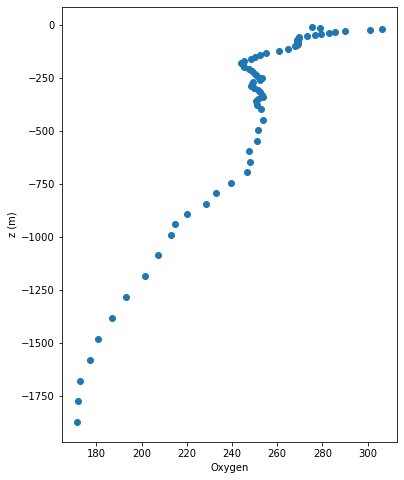

In [18]:
plt.figure(figsize=(6,8))
plt.xlabel('Oxygen')
plt.ylabel('z (m)')
plt.scatter(oxygen_rewrite[7], -z_rewrite[7])
plt.show()

In [19]:
median_oxygen_array = []

for x in oxygen_rewrite:
    if np.isnan(x).sum() == 1 and len(x) == 1:
        median_oxygen_array.append(np.nan)
    else:
        median_oxygen_array.append(np.median(x[~np.isnan(x)]))

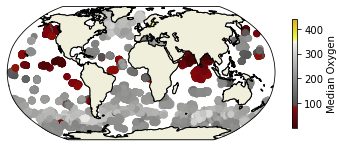

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()})
im = ax.scatter(ds3.lon.values, ds3.lat.values, c=median_oxygen_array, 
                transform=ccrs.PlateCarree(),cmap=cmocean.cm.oxy)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, edgecolor='black', zorder=1)
plt.colorbar(im, label='Median Oxygen', shrink=0.5)
fig.show()

In [ ]:
create_clean_dataset(ds3, output_type='xarray')

### WOD types of data: 
- Expendable Bathythermograph – XBT : temperature
- Profiling Float – PFL: similar to ctd, but more data, still MISMATCH dimension
- Ocean Station Data – OSD: CTD + Ox + trace (alkalinity, isotope) + wind, usually available for old data
- Moored buoy data - mrb: CTD
- Glider data - gld: CTD with Ox
- Drifting buoy data - drb: CTD with Ox
- High-resolution Conductivity-Temperature-Depth – CTD: CTD with Ox
- Autonomous Pinniped data - apb: CTD 

Data description: https://www.ncei.noaa.gov/sites/default/files/2020-04/wodreadme_0.pdf 


In [12]:
WOD_whole_process(year_range=range(1960,2022), sensor_type_range=['ctd', 'pfl'], save=True, datatype='dataframe',
                  storage_folder='/shared/marn5895/data/HungJosiahProject/NCEI_cleaned/')

1960: proccessing
1960: No ctd data
1960: No pfl data
1961: proccessing
_ctd_1961: No Oxygen available
_ctd_1961: No Chlorophyll available
1961: No pfl data
1962: proccessing
_ctd_1962: No Oxygen available
_ctd_1962: No Salinity available
_ctd_1962: No Chlorophyll available
1962: No pfl data
1963: proccessing
_ctd_1963: No Oxygen available
_ctd_1963: No Salinity available
_ctd_1963: No Chlorophyll available
1963: No pfl data
1964: proccessing
_ctd_1964: No Oxygen available
_ctd_1964: No Chlorophyll available
1964: No pfl data
1965: proccessing
1965: No ctd data
1965: No pfl data
1966: proccessing
_ctd_1966: No Oxygen available
_ctd_1966: No Chlorophyll available
1966: No pfl data
1967: proccessing
_ctd_1967: No Oxygen available
_ctd_1967: No Chlorophyll available
1967: No pfl data
1968: proccessing
_ctd_1968: No Oxygen available
_ctd_1968: No Chlorophyll available
1968: No pfl data
1969: proccessing
_ctd_1969: No Oxygen available
_ctd_1969: No Chlorophyll available
1969: No pfl data
19